In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# basis function in rbf
def gaussian_like_basis(x,mean,sigma):
    return np.exp(-np.linalg.norm(x - mean)/sigma)

In [3]:
# design matrix (X_data.shape[0] * J)
def design_matrix(X_data, J):
    kmeans, sigma = KMeans(n_clusters=J, random_state=0).fit(X_data), np.std(X_data)
    U = np.zeros((X_data.shape[0], J))
    for i in range(X_data.shape[0]):
        for j in range(J):
            U[i][j] = gaussian_like_basis(X_data[i], kmeans.cluster_centers_[j], sigma)  
    return U

In [4]:
# Quantize the states (discretize the state
def discretization(env, obs):
    n_states = 40
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled

In [5]:
# tabular_steps = []

# get tabular of q
def tabular_car_climb():
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    obs = env.reset()
    
    #  Switching on image engine will slow down the process
    # env.render()
    # Some initializations
    n_states = 40
    episodes = 50
    initial_lr = 1.0
    min_lr = 0.005
    gamma = 0.99
    max_stps = 300
    epsilon = 0.05
    env = env.unwrapped
    env.seed()
    np.random.seed(0)

    q_table = np.zeros((n_states, n_states, env.action_space.n))
    each_step_number = []
    for episode in range(episodes):
        print(episode)
        obs = env.reset()
        rewards = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
            # env.render()
            pos, vel = discretization(env, obs)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
            else:
                a = np.argmax(q_table[pos][vel])
            obs, reward, terminate,_ = env.step(a)
            rewards += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs)
            
            # Q function update
            q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
            steps += 1
            if terminate:
                each_step_number.append(steps)
                break
#     while True:
#         env.render()
    return q_table, each_step_number

# Observation:
## Type: Box(2) from official documentation of mountain car
        Num    Observation               Min            Max
        0      Car Position              -1.2           0.6
        1      Car Velocity              -0.07          0.07

In [6]:
# rbf fit tabular
def rbf_tabular(q_table, J):
    n_state = 40 # should be in line with that in function tabular_car_climb
    position_discrete, velocity_discrete = np.linspace(-1.2, 0.6, n_state), np.linspace(-0.07, 0.07, n_state)
    X_data = np.zeros((len(position_discrete)*len(velocity_discrete), 2))
    count = 0
    for i in range(len(position_discrete)):
        for j in range(len(velocity_discrete)):
            X_data[count][0], X_data[count][1] = position_discrete[i], velocity_discrete[j]
            count += 1
            
    U = design_matrix(X_data, J)
    q_table = q_table.reshape(-1, 3)
    print("U shape:", U.shape)
    print("q_table shape:", q_table.shape)
    # w estimation  20*3
    w = np.dot((np.linalg.inv(np.dot(U.T, U))), U.T) @ q_table
    rbf_matrix = np.dot(U, w)
    rbf_matrix = rbf_matrix.reshape(n_state, n_state, 3)
    return rbf_matrix
    

In [7]:
def rbf_call_climb(rbf_matrix, episodes=10):
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    obs = env.reset()
    
    #  Switching on image engine will slow down the process
#     env.render()
    # Some initializations
    n_states = 40
    initial_lr = 1.0
    min_lr = 0.005
    gamma = 0.99
    max_stps = 300
    epsilon = 0.05
    env = env.unwrapped
    env.seed()
    np.random.seed(0)

    each_step_number = []
    for episode in range(episodes):
        print(episode)
        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
        steps = 0
        while True:
#             env.render()
            pos, vel = discretization(env, obs)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
            else:
                a = np.argmax(rbf_matrix[pos][vel])
            obs, reward, terminate,_ = env.step(a)
            total_reward += abs(obs[0]+0.5)
            steps += 1
            if terminate:
                each_step_number.append(steps)
                break
#     while True:
#         env.render()
    return each_step_number

In [8]:
# get q_table and its steps on each epoch
q_table, tabular_steps = tabular_car_climb()
print(tabular_steps)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[35682, 900, 9951, 1950, 2722, 6159, 818, 835, 1741, 824, 1026, 891, 907, 1012, 1131, 2638, 689, 546, 3181, 1341, 635, 3311, 8035, 783, 1087, 975, 1184, 613, 989, 587, 1011, 554, 799, 1597, 1716, 786, 2645, 1625, 1566, 1676, 1050, 1312, 2270, 956, 639, 526, 1240, 1660, 483, 468]


In [9]:
# get rbf approximator
rbf_matrix_20 = rbf_tabular(q_table, 20)
rbf_matrix_40 = rbf_tabular(q_table, 40)
rbf_matrix_80 = rbf_tabular(q_table, 80)
rbf_matrix_120 = rbf_tabular(q_table, 120)
rbf_matrix_200 = rbf_tabular(q_table, 200)
rbf_matrix_500 = rbf_tabular(q_table, 500)

U shape: (1600, 20)
q_table shape: (1600, 3)
U shape: (1600, 40)
q_table shape: (1600, 3)
U shape: (1600, 80)
q_table shape: (1600, 3)
U shape: (1600, 120)
q_table shape: (1600, 3)
U shape: (1600, 200)
q_table shape: (1600, 3)
U shape: (1600, 500)
q_table shape: (1600, 3)


In [10]:
# climb hill using rbf
episodes=10

step_20 = rbf_call_climb(rbf_matrix_20, episodes)
step_40 = rbf_call_climb(rbf_matrix_40, episodes)
step_80 = rbf_call_climb(rbf_matrix_80, episodes)
step_120 = rbf_call_climb(rbf_matrix_120, episodes)
step_200 = rbf_call_climb(rbf_matrix_200, episodes)
step_500 = rbf_call_climb(rbf_matrix_500, episodes)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


mean steps: 2354.44


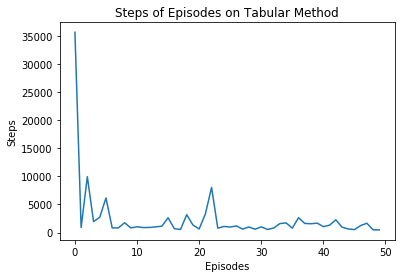

In [11]:
# steps plots on tabular
fig, ax = plt.subplots()
ax.plot(tabular_steps)
ax.set_title("Steps of Episodes on Tabular Method")
ax.set_xlabel("Episodes")
ax.set_ylabel("Steps")
print("mean steps:", np.mean(tabular_steps))

Text(0, 0.5, 'Steps')

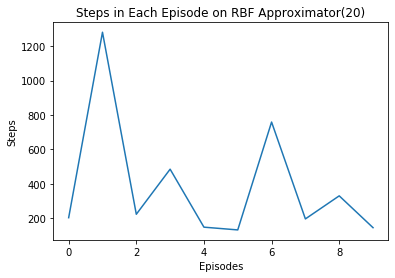

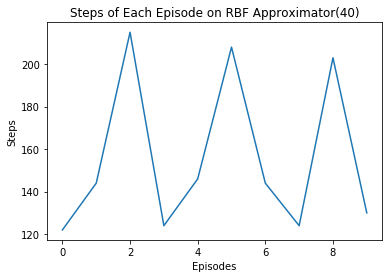

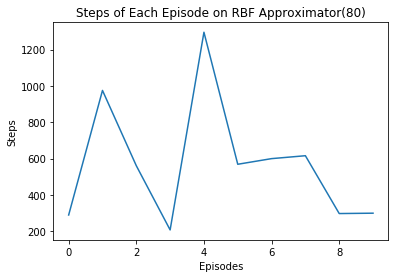

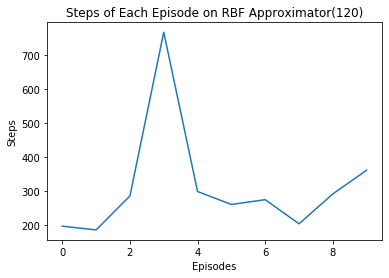

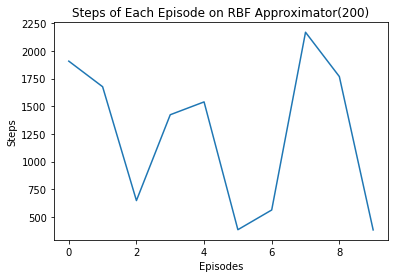

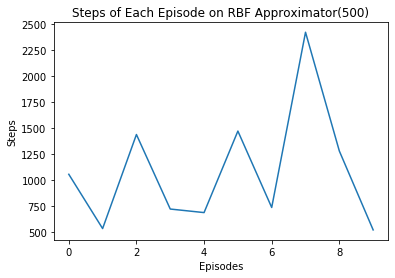

In [12]:
# steps plots on rbf approximator
fig1, ax1 = plt.subplots()
ax1.plot(step_20)
ax1.set_title("Steps in Each Episode on RBF Approximator(20)")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Steps")

fig2, ax2 = plt.subplots()
ax2.plot(step_40)
ax2.set_title("Steps of Each Episode on RBF Approximator(40)")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Steps")

fig3, ax3 = plt.subplots()
ax3.plot(step_80)
ax3.set_title("Steps of Each Episode on RBF Approximator(80)")
ax3.set_xlabel("Episodes")
ax3.set_ylabel("Steps")

fig4, ax4 = plt.subplots()
ax4.plot(step_120)
ax4.set_title("Steps of Each Episode on RBF Approximator(120)")
ax4.set_xlabel("Episodes")
ax4.set_ylabel("Steps")

fig5, ax5 = plt.subplots()
ax5.plot(step_200)
ax5.set_title("Steps of Each Episode on RBF Approximator(200)")
ax5.set_xlabel("Episodes")
ax5.set_ylabel("Steps")

fig6, ax6 = plt.subplots()
ax6.plot(step_500)
ax6.set_title("Steps of Each Episode on RBF Approximator(500)")
ax6.set_xlabel("Episodes")
ax6.set_ylabel("Steps")

Text(0, 0.5, 'Steps')

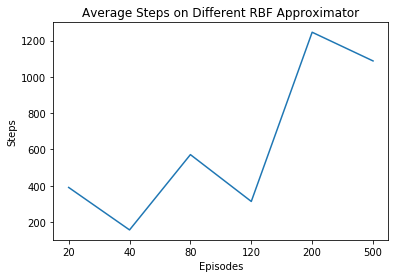

In [13]:
# compare different rbf basis function number
step_average = [np.mean(step_20), np.mean(step_40), np.mean(step_80), np.mean(step_120), np.mean(step_200), np.mean(step_500)]
fig7, ax7 = plt.subplots()
ax7.plot(step_average)
ax7.set_title("Average Steps on Different RBF Approximator")
ax7.set_xlabel("Episodes")
plt.xticks(np.arange(6), ('20','40','80','120','200','500'))
ax7.set_ylabel("Steps")

In [14]:
# loss calculation
from sklearn.metrics import mean_squared_error

q_table_c = q_table.reshape(-1)

rbf_matrix_20_c = mean_squared_error(q_table_c, rbf_matrix_20.reshape(-1))
rbf_matrix_40_c = mean_squared_error(q_table_c, rbf_matrix_40.reshape(-1)) 
rbf_matrix_80_c = mean_squared_error(q_table_c, rbf_matrix_80.reshape(-1)) 
rbf_matrix_120_c = mean_squared_error(q_table_c, rbf_matrix_120.reshape(-1)) 
rbf_matrix_200_c = mean_squared_error(q_table_c, rbf_matrix_200.reshape(-1))  
rbf_matrix_500_c = mean_squared_error(q_table_c, rbf_matrix_500.reshape(-1))

Text(0, 0.5, 'MSE Value')

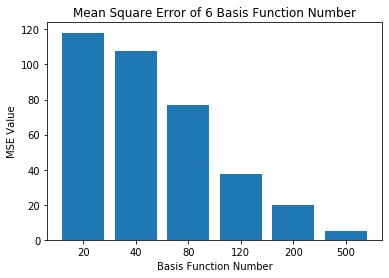

In [15]:
plt.bar(x= ["20", "40", "80", "120", "200", "500"], height= [rbf_matrix_20_c,rbf_matrix_40_c,rbf_matrix_80_c,rbf_matrix_120_c,rbf_matrix_200_c,rbf_matrix_500_c])
plt.title("Mean Square Error of 6 Basis Function Number")
plt.xlabel("Basis Function Number")
plt.ylabel("MSE Value")

Text(0.5, 1.0, 'Contour of Action 2 in Q Table')

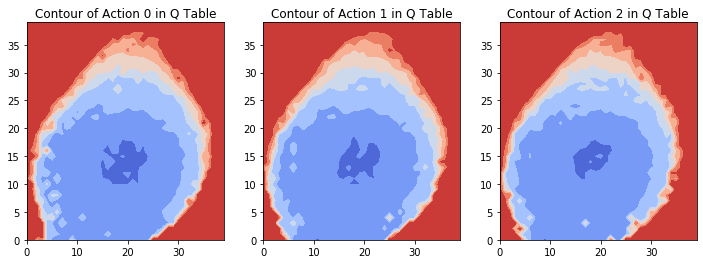

In [16]:
# contour
x_range, y_range = range(40), range(40)

con, ax_con = plt.subplots(1, 3, figsize=(12, 4))
ax_con[0].contourf(x_range, y_range, q_table[:,:,0], cmap='coolwarm')
ax_con[1].contourf(x_range, y_range, q_table[:,:,1], cmap='coolwarm')
ax_con[2].contourf(x_range, y_range, q_table[:,:,2], cmap='coolwarm')
ax_con[0].set_title("Contour of Action 0 in Q Table")
ax_con[1].set_title("Contour of Action 1 in Q Table")
ax_con[2].set_title("Contour of Action 2 in Q Table")

Text(0.5, 1.0, 'Action 2 in RBF(80) Approximation')

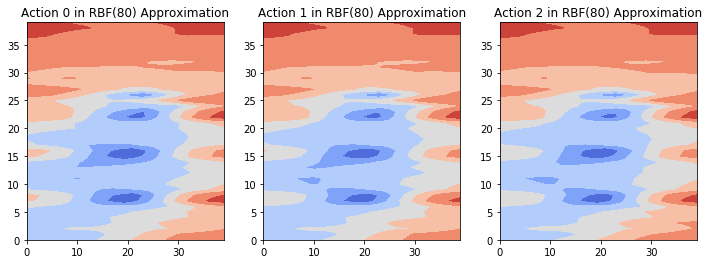

In [17]:
con1, ax_con1 = plt.subplots(1, 3, figsize=(12, 4))
ax_con1[0].contourf(x_range, y_range, rbf_matrix_80[:,:,0], cmap='coolwarm')
ax_con1[1].contourf(x_range, y_range, rbf_matrix_80[:,:,1], cmap='coolwarm')
ax_con1[2].contourf(x_range, y_range, rbf_matrix_80[:,:,2], cmap='coolwarm')
ax_con1[0].set_title("Action 0 in RBF(80) Approximation")
ax_con1[1].set_title("Action 1 in RBF(80) Approximation")
ax_con1[2].set_title("Action 2 in RBF(80) Approximation")

Text(0.5, 1.0, 'Action 2 in RBF(80) Approximation')

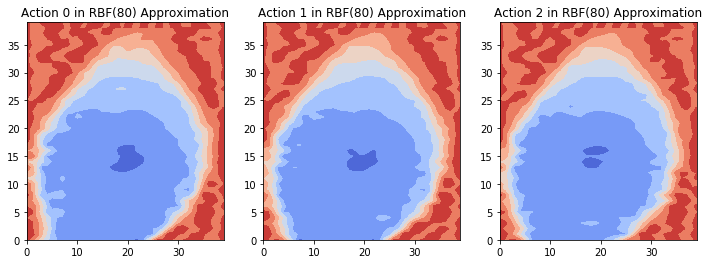

In [18]:
con2, ax_con2 = plt.subplots(1, 3, figsize=(12, 4))
ax_con2[0].contourf(x_range, y_range, rbf_matrix_500[:,:,0], cmap='coolwarm')
ax_con2[1].contourf(x_range, y_range, rbf_matrix_500[:,:,1], cmap='coolwarm')
ax_con2[2].contourf(x_range, y_range, rbf_matrix_500[:,:,2], cmap='coolwarm')
ax_con2[0].set_title("Action 0 in RBF(80) Approximation")
ax_con2[1].set_title("Action 1 in RBF(80) Approximation")
ax_con2[2].set_title("Action 2 in RBF(80) Approximation")

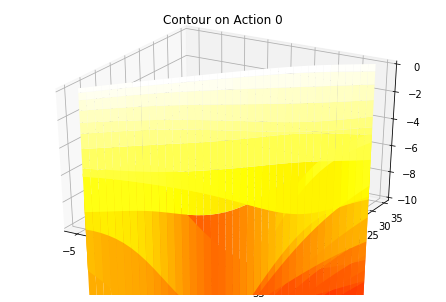

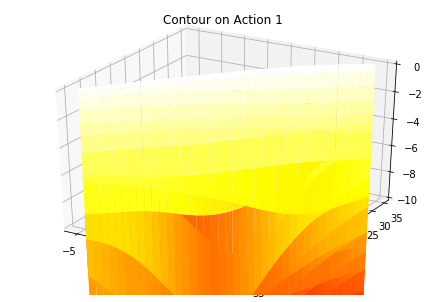

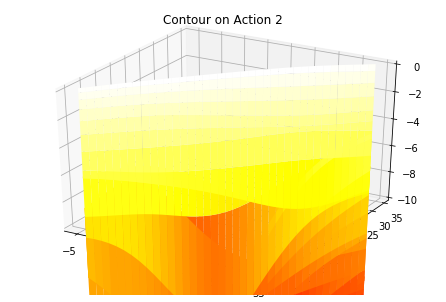

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_pic(X, Y, Z, z_max, title, z_min=-10):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.hot)
    ax.set_zlim(z_min, z_max)
    ax.set_title(title)
    plt.show()
    
draw_pic(range(-5, 35), range(-5, 35), rbf_matrix_40[:,:,0], 0, "Contour on Action 0")
draw_pic(range(-5, 35), range(-5, 35), rbf_matrix_40[:,:,1], 0, "Contour on Action 1")
draw_pic(range(-5, 35), range(-5, 35), rbf_matrix_40[:,:,2], 0, "Contour on Action 2")